In [16]:
import skimage

print(skimage.__version__)

0.13.0


In [17]:
import numpy as np
import os
import pandas as pd
import scipy.ndimage
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import math
import dicom      #need to install this package
from sklearn.cluster import KMeans
#from tqdm import tqdm
#import tensorflow

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

#
DATA_PATH = "/scratch2/sdash/data/stage1"
allPatients = os.listdir(DATA_PATH)
allPatients.sort()

labels_df = pd.read_csv('/scratch2/sdash/data/stage1_labels.csv', index_col=0)

labels_df.head()


,cancer
id,
0015ceb851d7251b8f399e39779d1e7d,1
0030a160d58723ff36d73f41b170ec21,0
003f41c78e6acfa92430a057ac0b306e,0
006b96310a37b36cccb2ab48d10b49a3,1
008464bb8521d09a42985dd8add3d0d2,1


In [18]:
#extract the labelled patients which has a label in the labels_df file
patients = []
unlabeled = 0
for num,patient in enumerate(allPatients):
    try:
        haslabel = labels_df.get_value(patient,'cancer')
        patients.append(patient)
        
    except:
        #print(patient+" is unlabelled")
        unlabeled = unlabeled+1

print("labelled patients",len(patients))
print("ALL Patients",len(allPatients))
print("Unlabelled patients",unlabeled)

('labelled patients', 1397)
('ALL Patients', 1595)
('Unlabelled patients', 198)


In [19]:
for patient in patients[:1]:
    path = DATA_PATH + '/' + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    #print((slices[1].pixel_array))
    #print(slices[0])
    

In [20]:
def histogram(pixels):
    plt.hist(pixels.flatten(), bins=50, color='c')
    plt.xlabel("Hounsfield Units(HU)")
    plt.ylabel("Frequency")
    plt.show()

In [21]:
#just visualizing the images
IMG_PX_SIZE = 150

def SeeData():
    for patient in patients[:2]:
        label = labels_df.get_value(patient, 'cancer')
        path = DATA_PATH + '/' + patient
        slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
        slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    
        #uncomment below code when we need to visualize the labels also
        #print(label)
        #plt.imshow(slices[0].pixel_array,cmap='gray')
    
        fig = plt.figure()
        for num,each_slice in enumerate(slices[:12]):
            y = fig.add_subplot(3,4,num+1)
            new_img = cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE))
            y.imshow(new_img)
        plt.show()
    

In [22]:
def load_scan(path):
    #print(path)
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    #print(len(slices))
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness #we are changing the slicethickness 
        
    return slices


In [23]:
def get_pixels_hu(slices):
    #this function will stack or stitch the 2D images to form a 3D image
    Image3d = np.stack([s.pixel_array for s in slices])
    
    #Converting the pixels to a value of 16-bit int values
    Image3d = Image3d.astype(np.int16)

    #plt.imshow(Image3d[70],cmap='gray')
    #plt.show()
        
    # -2000 is by default set in the edges of the images where the cylindrical 
    # The intercept is usually -1024, so air is approximately 0
    Image3d[Image3d == -2000] = 0
    #print(Image3d[0])
    
    #plt.hist(Image3d[0].flatten(), bins=50, color='c')
    #plt.xlabel("Hounsfield Units(HU)")
    #plt.ylabel("Frequency")
    #plt.show()
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):   
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        #print(intercept,slope)
        if slope != 1:
            Image3d[slice_number] = slope * Image3d[slice_number].astype(np.float64)
            Image3d[slice_number] = Image3d[slice_number].astype(np.int16)
            
        Image3d[slice_number] = Image3d[slice_number] + np.int16(intercept)
    
    #print(Image3d[0])
    #at this point Image3D contains the 
    #plt.hist(Image3d[0].flatten(), bins=50, color='c')
    #plt.xlabel("Hounsfield Units(HU)")
    #plt.ylabel("Frequency")
    #plt.show()
    
    return np.array(Image3d, dtype=np.int16)


In [24]:
def samplingToEvenSpacing(image, allscans, new_spacing=[1,1,1]):
    
    spacing = map(float, ([allscans[0].SliceThickness] + allscans[0].PixelSpacing))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

In [25]:
def patient_pixel(i):
    AllSlices = load_scan(DATA_PATH + '/' + patients[i])
    patient = patients[i]
    #print(AllSlices[0].SliceThickness)
    patient_pixels_3d = get_pixels_hu(AllSlices)
    
    patient_pixels_3d,_ = samplingToEvenSpacing(patient_pixels_3d, AllSlices, [1,1,1])
    
    #to see histogram view of the 3d image 
    #plt.hist(patient_pixels_3d[0].flatten(), bins=50, color='c')
    #plt.xlabel("Hounsfield Units(HU)")
    #plt.ylabel("Frequency")
    #plt.show()
    
    #print(patients[i]) #patient ID
    
    # Show some slice in the middle
    #plt.imshow(patient_pixels_3d[70],cmap='gray')
    #plt.show()
    
    return patient, patient_pixels_3d


In [26]:
patientID,Patient3D = patient_pixel(1)
print(Patient3D[1].shape)
print(patientID)
#plt.imshow(Patient3D[1])
#histogram(Patient3D[1])

(298, 298)
0030a160d58723ff36d73f41b170ec21


In [27]:
#trying to 3D View the image

def make_mesh(image, threshold=-300, step_size=1):

    print "Transposing surface"
    p = image.transpose(2,1,0)
    
    print "Calculating surface"
    #verts, faces, norm, val = measure.marching_cubes(p, threshold, step_size=step_size, allow_degenerate=True) 
    verts, faces = measure.marching_cubes(p, threshold)
    
    return verts, faces

def plot_3d(verts, faces):
    
    print "Drawing"
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    face_color = [1, 1, 0.9]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    ax.set_axis_bgcolor((0.7, 0.7, 0.7))
    plt.show()

In [28]:
patientID,Patient3D = patient_pixel(1)
#vs,fs = make_mesh(Patient3D,350)
#plot_3d(vs,fs)

In [29]:
#using K-means and erosion, dilation and morphology tools of opencv
# we are trying to segment the lungs data to a small set of pixels to make the  3D small in size
# a nice small sized 3D image may give us better results in tensorflow

def lungmask(patientImg, display=False):
    row_size= patientImg.shape[0]
    col_size = patientImg.shape[1]
    
    #normalization of the pixel data
    mean = np.mean(patientImg)
    std = np.std(patientImg)
    patientImg = patientImg-mean
    patientImg = patientImg/std
  
    middle = patientImg[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(patientImg)
    min = np.min(patientImg)
  
    patientImg[patientImg==max]=mean
    patientImg[patientImg==min]=mean
    #
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    mask = 1
    try:
        kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
        centers = sorted(kmeans.cluster_centers_.flatten())
        threshold = np.mean(centers)
        thresh_img = np.where(patientImg<threshold,1.0,0.0)  # thresholding the image to 1 and 0 values only

        # Doing Erosion and dilation to remove the small structures from the lungs 

        eroded = morphology.erosion(thresh_img,np.ones([3,3]))
        dilation = morphology.dilation(eroded,np.ones([8,8]))
    
        # Different labels are displayed in different colors
        labels = measure.label(dilation)
        #nlabels = scipy.ndimage.measurements.label(dilation)
    
    
        #labels = nlabels[0].astype(np.uint8)
        #print(labels.dtype)
        label_vals = np.unique(labels)
        regions = measure.regionprops(labels)
        good_labels = []
        for prop in regions:
            B = prop.bbox
            if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
                good_labels.append(prop.label)
        mask = np.ndarray([row_size,col_size],dtype=np.uint8)
        mask[:] = 0
        #print(mask.dtype)

        #
        #  After just the lungs are left, we do another large dilation
        #  in order to fill in and out the lung mask 
        #
        for N in good_labels:
            mask = mask + np.uint8(np.where(labels==N,1,0))

        #print(mask.dtype)
        mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

        if (display):
            fig, ax = plt.subplots(3, 2, figsize=[12, 12])
            ax[0, 0].set_title("Original")
            ax[0, 0].imshow(patientImg, cmap='gray')
            ax[0, 0].axis('off')
            ax[0, 1].set_title("Kmeans giving us 2 clusters")
            ax[0, 1].imshow(thresh_img, cmap='gray')
            ax[0, 1].axis('off')
            ax[1, 0].set_title("Cleared image after Erosion and Dilation")
            ax[1, 0].imshow(dilation, cmap='gray')
            ax[1, 0].axis('off')
            ax[1, 1].set_title("Colored Labels")
            ax[1, 1].imshow(labels)
            ax[1, 1].axis('off')
            ax[2, 0].set_title("Final Mask")
            ax[2, 0].imshow(mask, cmap='gray')
            ax[2, 0].axis('off')
            ax[2, 1].set_title("Apply Mask on Original")
            ax[2, 1].imshow(mask*patientImg, cmap='gray')
            ax[2, 1].axis('off')

            plt.show()
            
    except:
        pass 
    
    return mask*patientImg

#print(len(Patient3D))
#maskedImage = lungmask(Patient3D[300],True)

In [31]:
def chunks(l, n):
    #print(int(n))
    try:
        for i in xrange(0, len(l), int(n)): yield l[i:i + int(n)]
    except:
        pass
        
def mean(l):
    return sum(l) / len(l)


def SaveData():
    TFData = []
    print("Started")
    for i,ithPatient in enumerate(patients[751:len(patients)]):
        
        patientID,Patient3DPixels = patient_pixel(i)
        Stage1label = labels_df.get_value(patientID,'cancer')
        if( i==2):
            print("1 Pass successful")
        if (i%50 == 0):
            print(patientID)
            print(len(Patient3DPixels),i)
            
        
        if Stage1label == 1: 
            oneHotlabel=np.array([0,1])
        elif Stage1label == 0: 
            oneHotlabel=np.array([1,0])
        
        print(Stage1label)
        maskedImage3D = []
        for j,scan in enumerate(Patient3DPixels):
            maskedImage = lungmask(scan,False)
            maskedImage3D.append(maskedImage)
        
        new_slices = []
        img_px_size = 64
        hm_slices = 32
        #Resizing to smaller images
        slices = [cv2.resize(np.array(each_slice),(img_px_size,img_px_size)) for each_slice in maskedImage3D]
    
        chunk_sizes = math.ceil(len(slices) / hm_slices)
        for slice_chunk in list(chunks(slices, chunk_sizes)):
            slice_chunk = list(map(mean, zip(*slice_chunk)))
            new_slices.append(slice_chunk)

        #len(new_slices is less than hm_slices)
        if( len(new_slices) < hm_slices ):
            for i in range(len(new_slices),hm_slices):
                new_slices.append(new_slices[len(new_slices)])
        elif(len(new_slices) > hm_slices):
            #print("length =")
            #print(len(new_slices))
            new_slices = new_slices[0:hm_slices]
        
        #plt.imshow(maskedImage3D[0])
        TFData.append([new_slices,oneHotlabel,patientID])
        
    np.save("TensorflowData3.npy",TFData)
    print("Save Data Completed ")
    
#Save the  data in disc
SaveData()

Started
0015ceb851d7251b8f399e39779d1e7d
(390, 0)
1
0
1 Pass successful
0
1
1
0
0
0
1
0
0
0
0
0
0
1
0
0
1
1
0
0
0
0
0
0
0
1
0
0
0
1
1
0
1
0
0
1
1
0
1
0
0
1
0
0
0
0
0
0
08acb3440eb23385724d006403feb585
(397, 50)
0
0
0
1
0
0
0
0
0
1
0
1
1
0
1
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
1
0
0
0
0
12e0e2036f61c8a52ee4471bf813c36a
(268, 100)
1
0
0
1
0
1
1
0
0
0
1
0
0
1
0
0
0
0
1
0
0
0
0
0
0
0
1
1
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1be4cf2de84adac4de0e090c9a15461c
(282, 150)
0
0
0
0
0
0
1
0
1
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
0
0
1
1
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
274a81c75d244187247789bd71de2b3a
(331, 200)
1
0
0
1
0
0
0
0
0
0
1
1
0
0
1
0
0
1
1
1
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
1
0
0
1
0
0
0
0
1
0
0
1
0
1
1
2f4645c27f9806daffe7e9d013b4b7eb
(301, 250)
0
0
0
0
1
0
0
0
1
0
1
0
1
0
0
0
1
0
0
0
1
0
1
0
0
0
1
0
0
1
0
1
0
0
0
0
0
0
1
0
0
0
1
0
1
0
1
0
0
1
3557455d81f42ee54ad0544f36933e9a
(330, 300)
0
0
0
0
1
0
0
0
0
0
0
1
0
0
1
1
1
0
0
1
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0

200


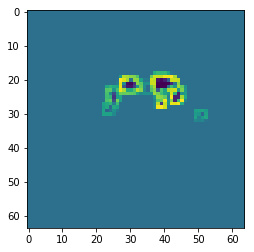

In [38]:
LoadData = np.load("TensorflowData.npy")
print(len(LoadData))
#print(LoadData[0][0][0])
#plt.imshow(LoadData[0][0][1])
#vs,fs = make_mesh(LoadData[0][0],350)
#plot_3d(vs,fs)